In [2]:
#Helper Functions for Data processing:

import pandas as pd
import numpy as np
import geopandas as gpd
import dask 
import numba

In [3]:
def read_spatial(path):
    '''
    Function to read spatial data and converts to ESPG 3435
    Input: path to the data file
    Output: a gpd object 
    '''
    file=gpd.read_file(path)
    file=file.to_crs("EPSG:3435")
    print(path, file.crs)
    return file

data/com_areas_chi EPSG:3435


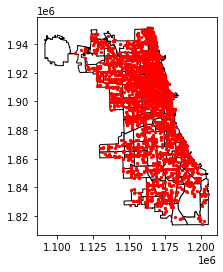

In [103]:
#GET TOY TEST DATA:
com_areas = read_spatial("data/com_areas_chi")
bike_rack_points = pd.read_csv('data/Bike_Racks.csv')
bike_rack_points = bike_rack_points.rename(columns = {"LOCATION":"geometry"})
bike_racks = gpd.GeoDataFrame(
    bike_rack_points, geometry=gpd.points_from_xy(bike_rack_points.Longitude,
                                                  bike_rack_points.Latitude), 
    crs="EPSG:4326")
bike_racks = bike_racks.to_crs("EPSG:3435")
bike_racks = bike_racks[["RackID", "Address", "F12", "F13", "geometry"]]
bike_racks["F12"] = bike_racks["F12"].round(1)
bike_racks["F13"] = bike_racks["F13"].round(1)
base = com_areas.plot(color='white', edgecolor='black')
bike_racks_small.plot(ax=base, marker='o', color='red', markersize=5);

In [97]:
def conduct_point_to_polygon(polygon_data, poly_unique_id, other_file):
    '''
    A function that creates a new dataset with spatial join of pyolgon data to points
    Inputs:
        polygon_data (gpd): polygon data (i.e. Community Areas)
        poly_unique_id (list of strings): the unique identifiers of the polygon spatial data
        other_file (gpd): another point-based gpd. Data from this will be aggregated 
                          to the polygon scale
        agg_dict (dict keys: strings - col names in point data
                       values: strings or list of strings - how to aggregate)
                       
    Output:
        the polygon_data dataframe updated with the new column
    Note: .size suggestion from here: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    '''
    spatial_join = gpd.sjoin(other_file, 
                             polygon_data[poly_unique_id + ["geometry"]], 
                             how="inner", 
                             op='intersects')
    
    return spatial_join
#USE CASE: 
#INPUT com areas and point data with all of the ND.. features
#We get the com area the point data is in


In [104]:
#Toy Test:
bike_ag_dict = {'RackID': ['min', 'max'], 'Address': 'size'}

com_area_w_bike = conduct_point_to_polygon(com_areas, 
                                           ["community", "area_numbe"], 
                                           bike_racks, 
                                           bike_ag_dict)
com_area_w_bike

,RackID,Address,F12,F13,geometry,index_right,community,area_numbe
0,3492,1391 N Milwaukee Ave,41.9,-87.7,POINT (1164227.030 1909454.074),24,WEST TOWN,24
2,5945,1001 N Damen Ave,41.9,-87.7,POINT (1162920.382 1906709.783),24,WEST TOWN,24
9,483,1943 W North Ave,41.9,-87.7,POINT (1163003.301 1910601.713),24,WEST TOWN,24
15,4118,1147 N Western Ave,41.9,-87.7,POINT (1160251.418 1907653.047),24,WEST TOWN,24
29,6518,2222 W North Ave,41.9,-87.7,POINT (1161205.566 1910644.139),24,WEST TOWN,24
...,...,...,...,...,...,...,...,...
4856,5419,6566 N Avondale Ave,42.0,-87.8,POINT (1125123.306 1942869.087),76,EDISON PARK,9
4921,3616,6700 N Olmsted Ave,42.0,-87.8,POINT (1124580.663 1943783.780),76,EDISON PARK,9
5056,3589,6755 N Northwest Highway Hwy,42.0,-87.8,POINT (1124321.999 1944489.194),76,EDISON PARK,9
4422,4492,9130 S University Ave,41.7,-87.6,POINT (1185424.432 1844638.524),42,BURNSIDE,47


In [111]:
def agg_cell_data(df, cols_to_group_by, ag_dict):
    '''
    Function to aggregate point weather data the cols_to_group_by and perform aggregations
    as specificed in the aggregation_dictionary
    Inputs:
        df the dataframe
        cols_to_group_by (list of strings): columns in df
        ag_dict (dictionary of strings to list of strings): maps column names to 
                                    aggregation operations
    Outputs:
        aggregated df
    '''
    df_new = df.groupby(cols_to_group_by).agg(ag_dict)
    
    return df_new

#USE CASE: ONCE WE HAVE PREVIOUS DATA, WE GROUP BY COM AREA, PERIOD, YEAR
# THEN WE AGGREGATE: MEAN, MAX OF DIFFERENT ND.. COLS


In [110]:
cols = ["area_numbe", "F12"]
ag_dict1 = {"RackID":"mean", "F13": ["min", "max"]}
bike_rack_agg = agg_cell_data(com_area_w_bike, cols_to_group_by = cols, 
                             ag_dict = ag_dict1)
bike_rack_agg


RackID   F13      
                        mean   min   max
area_numbe F12                          
1          42.0  3457.823529 -87.7 -87.7
10         42.0  3865.415385 -87.8 -87.8
11         42.0  3822.250000 -87.8 -87.8
12         42.0  2975.440000 -87.8 -87.7
13         42.0  3948.485714 -87.7 -87.7
...                      ...   ...   ...
75         41.7  4107.976744 -87.7 -87.6
76         42.0  2381.750000 -87.8 -87.8
77         42.0  3398.801653 -87.7 -87.7
8          41.9  3801.804965 -87.7 -87.6
9          42.0  3667.050000 -87.8 -87.8

[92 rows x 3 columns]

In [1]:
import rasterio

from rasterio.plot import show

from rasterio.plot import show_hist

from rasterio.mask import mask

from shapely.geometry import box

import geopandas as gpd

from fiona.crs import from_epsg

import pycrs

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


ModuleNotFoundError: No module named 'pycrs'

In [4]:
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

In [5]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [6]:
geo

,geometry
0,"POLYGON ((25.22000 60.00000, 25.22000 60.35000..."


In [9]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [10]:
coords = getFeatures(geo)

In [13]:
coords

[{'type': 'Polygon',
  'coordinates': [[[25.22, 60.0],
    [25.22, 60.35],
    [24.6, 60.35],
    [24.6, 60.0],
    [25.22, 60.0]]]}]